In [1]:
import pathlib
import os
import warnings
warnings.filterwarnings('ignore')

# Change to the project root directory
project_root = pathlib.Path().resolve().parent
os.chdir(project_root)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.models import ARIMA
from darts import TimeSeries
from darts import concatenate
from darts.metrics import mse as MSE
from darts.metrics import mae as MAE
from darts.models import SKLearnModel
import torch
from src.train import Trainer
from src.train import DartsBridge
from src.models import Classic_TCN
from src.models import AdditiveHybrid_ARMA_TCN
from src.diagnose import compute_erf


# Import Data

In [2]:
data_path = pathlib.Path("data/DCOILWTICO.csv")
print(f"Loading from: {data_path.absolute()}")
print(f"File exists: {data_path.exists()}")

data = pd.read_csv(data_path)
data.rename(columns = {"observation_date" : "date", "DCOILWTICO" : "price"}, inplace  = True)
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data["return"] = np.log(data["price"]) - np.log(data["price"].shift(1))
returns = data["return"].replace([np.inf, -np.inf], np.nan).dropna().astype("float32")

Loading from: /Users/victormp/Desktop/ml/ml-project/data/DCOILWTICO.csv
File exists: True


# Split Data

In [3]:
# Three-way split: 60% train, 20% validation, 20% test
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_end = int(len(returns) * train_ratio)
val_end = int(len(returns) * (train_ratio + val_ratio))

# Split the data
y_train = returns.iloc[:train_end]
y_val = returns.iloc[train_end:val_end]
y_test = returns.iloc[val_end:]

# Convert to darts TimeSeries objects
train_series = TimeSeries.from_values(y_train)
val_series = TimeSeries.from_values(y_val)
test_series = TimeSeries.from_values(y_test)

print(f"Train size: {len(train_series)} ({train_ratio*100}%)")
print(f"Validation size: {len(val_series)} ({val_ratio*100}%)")
print(f"Test size: {len(test_series)} ({(1-train_ratio-val_ratio)*100}%)")

Train size: 715 (60.0%)
Validation size: 239 (20.0%)
Test size: 239 (20.0%)


# Train AR Model

In [4]:
AR_ORDERS = [1, 5]
ar_model = {}
for ar_order in AR_ORDERS:
    try:
        ar_model[ar_order] = ARIMA.load(f"weights/model_weights_ar{ar_order}.pkl")
        print(f"Loaded model weights from weights/model_weights_ar{ar_order}.pkl")
        print(f"Model accessible under: model_ar{[ar_order]}")
    except (RuntimeError, FileNotFoundError) as e:
        ar_model[ar_order] = ARIMA(p=ar_order, d=0, q=0)
        ar_model[ar_order].fit(train_series)
        ar_model[ar_order].save(f'weights/model_weights_ar{ar_order}.pkl')
        print(f"Model accessible under: model_ar{ar_order}.pkl")

model_ar1 = ar_model[1]
model_ar5 = ar_model[5]


Loaded model weights from weights/model_weights_ar1.pkl
Model accessible under: model_ar[1]
Loaded model weights from weights/model_weights_ar5.pkl
Model accessible under: model_ar[5]


# Train TCN

In [5]:
try:
    # Only pass architecture parameters here
    model_classic_tcn = Classic_TCN(
        num_channels=[128, 128, 128], 
        kernel_size=[2, 2, 2], 
        dilations=[1, 2, 4],
        dropout=0.1
    )
    
    model_classic_tcn.load_state_dict(torch.load("weights/model_weights_classic_tcn.pth"))
    model_classic_tcn.eval()
    print(f"Loaded model weights from 'weights/model_weights_classic_tcn.pth'")

except (RuntimeError, FileNotFoundError) as e:
    print(f"Model architecture mismatch: {e}")
    print(f"Training new model...")
    # Training parameters go here
    model_classic_tcn = Trainer(
        model_type="classic",
        num_channels=[128, 128, 128],
        kernel_size=[2, 2, 2],
        dilations=[1, 2, 4],
        num_epochs=100, 
        lr=0.0001
    ).fit(y_train.values)
    torch.save(model_classic_tcn.state_dict(), "weights/model_weights_classic_tcn.pth")

Loaded model weights from 'weights/model_weights_classic_tcn.pth'


# Train Hybrid ARMA-TCN

In [7]:
try:
    # Only pass architecture parameters here
    model_hybrid_arma = AdditiveHybrid_ARMA_TCN(
        ar_order=1,
        ma_order=0,
        num_channels=[64]*7,
        kernel_size=[3]*7,
        dilations=[1, 2, 4, 8, 16, 32, 64],
        dropout=0.1

    )

    model_hybrid_arma.load_state_dict(torch.load("weights/model_weights_hybrid_arma.pth"))
    model_hybrid_arma.eval()
    print(f"Loaded model weights from 'weights/model_weights_hybrid_arma.pth'")

except (RuntimeError, FileNotFoundError) as e:
    print(f"Model architecture mismatch: {e}")
    print(f"Training new model...")
    # Training parameters go here
    model_hybrid_arma = Trainer(
        model_type="additive",
        ar_order=1,
        ma_order=0,
        num_channels=[64]*7,
        kernel_size=[3]*7,
        dilations=[1, 2, 4, 8, 16, 32, 64],
        num_epochs=100,
        lr=0.001
    ).fit(y_train.values)
    model_hybrid_arma = model_hybrid_arma.get_model()
    torch.save(model_hybrid_arma.state_dict(), "weights/model_weights_hybrid_arma.pth")

Model architecture mismatch: Error(s) in loading state_dict for AdditiveHybrid_ARMA_TCN:
	Missing key(s) in state_dict: "tcn.network.3.conv1.conv.bias", "tcn.network.3.conv1.conv.parametrizations.weight.original0", "tcn.network.3.conv1.conv.parametrizations.weight.original1", "tcn.network.3.conv2.conv.bias", "tcn.network.3.conv2.conv.parametrizations.weight.original0", "tcn.network.3.conv2.conv.parametrizations.weight.original1", "tcn.network.3.net.0.conv.bias", "tcn.network.3.net.0.conv.parametrizations.weight.original0", "tcn.network.3.net.0.conv.parametrizations.weight.original1", "tcn.network.3.net.3.conv.bias", "tcn.network.3.net.3.conv.parametrizations.weight.original0", "tcn.network.3.net.3.conv.parametrizations.weight.original1", "tcn.network.4.conv1.conv.bias", "tcn.network.4.conv1.conv.parametrizations.weight.original0", "tcn.network.4.conv1.conv.parametrizations.weight.original1", "tcn.network.4.conv2.conv.bias", "tcn.network.4.conv2.conv.parametrizations.weight.original0", 

# Effective Receptive Field Calculation

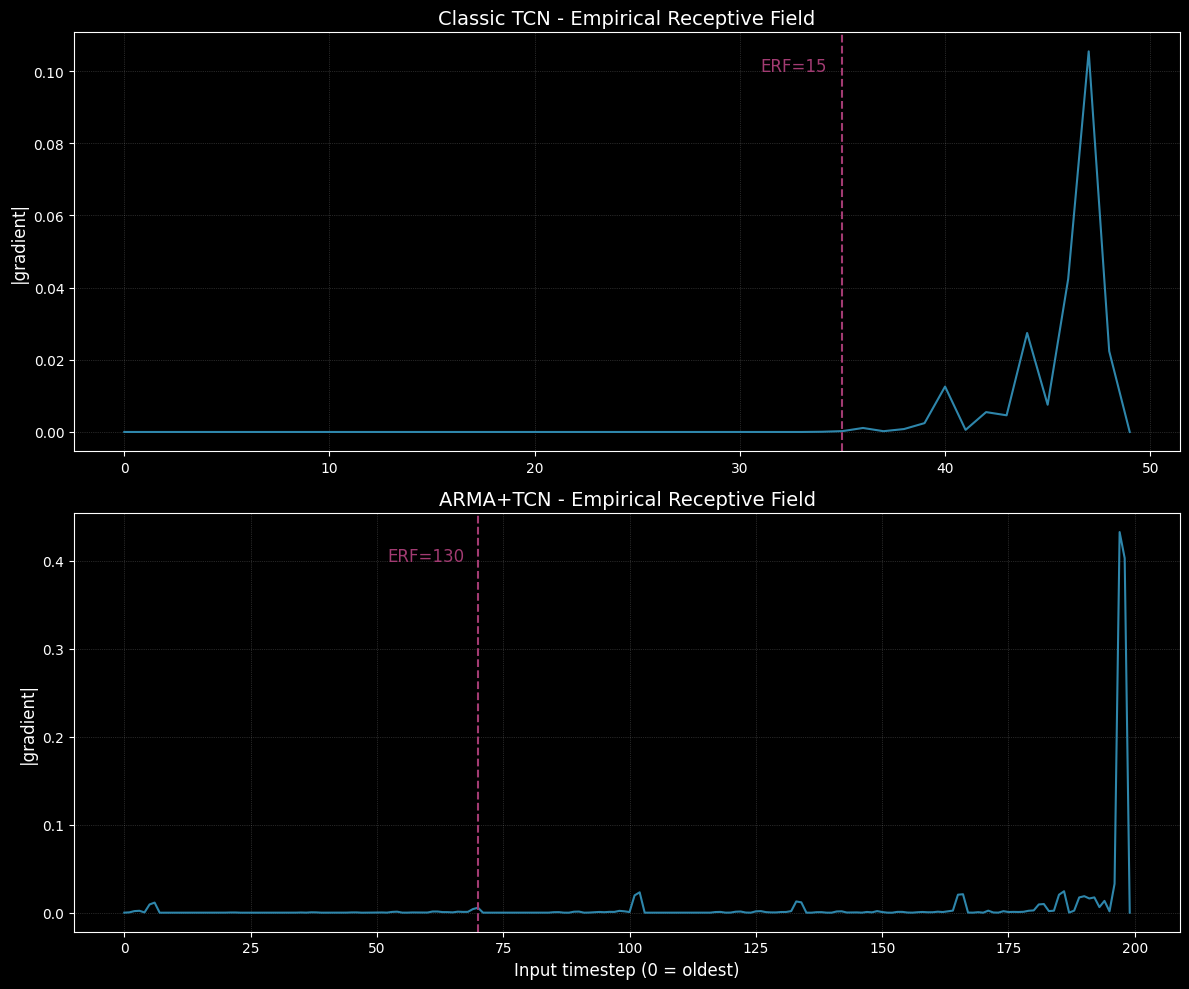

In [60]:
sensitivity_tcn = compute_erf(model_classic_tcn, sequence_length=100, device='mps')
sensitivity_arma = compute_erf(model_hybrid_arma, sequence_length=200, device='mps')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12, 10))

ax1.plot(sensitivity_tcn, color='#2E86AB')
ax1.axvline(x=50-15, linestyle='--', color='#A23B72')
ax1.text(x=31, y=0.1, s="ERF=15", color='#A23B72', fontsize=12)
ax1.set_ylabel('|gradient|', fontsize=12)
ax1.set_title('Classic TCN - Empirical Receptive Field', fontsize=14)
ax1.grid(alpha=0.3, linestyle=':', linewidth=0.5)

ax2.plot(sensitivity_arma, color='#2E86AB')
ax2.axvline(x=200-130, linestyle='--', color='#A23B72')
ax2.text(x=52, y=0.4, s="ERF=130", color='#A23B72', fontsize=12)
ax2.set_xlabel('Input timestep (0 = oldest)', fontsize=12)
ax2.set_ylabel('|gradient|', fontsize=12)
ax2.set_title('ARMA+TCN - Empirical Receptive Field', fontsize=14)
ax2.grid(alpha=0.3, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

# In-Sample Forecast Evaluation

In [53]:
# Retrain on combined training and validation sets
train_val_combined = concatenate([train_series, val_series], axis=0, ignore_time_axis=True)
return_series = TimeSeries.from_values(returns)
val_series_aligned = return_series[:val_end]

# In-Sample Forecast Evaluation (1-step, simple forecasting)
results_insample_mse_df = pd.DataFrame(columns=["1-step MSE"])
results_insample_mae_df = pd.DataFrame(columns=["1-step MAE"])

# AR models: use historical_forecasts on train_series
for ar in AR_ORDERS:
    model = ar_model[ar]
    forecast_series = model.historical_forecasts(
        series=train_val_combined,
        start=train_end,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True
    )
    results_insample_mse_df.loc[f"AR({ar})", "1-step MSE"] = MSE(val_series_aligned, forecast_series, intersect=True)
    results_insample_mae_df.loc[f"AR({ar})", "1-step MAE"] = MAE(val_series_aligned, forecast_series, intersect=True)

# Classic TCN: wrap in DartsBridge for 1-step simple forecasting
model_classic_tcn_darts = SKLearnModel(
    model=DartsBridge(model_classic_tcn),
    lags=15
)
model_classic_tcn_darts.fit(train_series)

forecast_series = model_classic_tcn_darts.historical_forecasts(
    series=train_val_combined,
    start=train_end,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True
)
results_insample_mse_df.loc["Classic TCN", "1-step MSE"] = MSE(val_series_aligned, forecast_series, intersect=True)
results_insample_mae_df.loc["Classic TCN", "1-step MAE"] = MAE(val_series_aligned, forecast_series, intersect=True)

# Hybrid ARMA+TCN: wrap in DartsBridge for 1-step simple forecasting
model_hybrid_arma_darts = SKLearnModel(
    model=DartsBridge(model_hybrid_arma),
    lags=130
)
model_hybrid_arma_darts.fit(train_series)

forecast_series = model_hybrid_arma_darts.historical_forecasts(
    series=train_val_combined,
    start=train_end,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True
)
results_insample_mse_df.loc["ARMA+TCN", "1-step MSE"] = MSE(val_series_aligned, forecast_series, intersect=True)
results_insample_mae_df.loc["ARMA+TCN", "1-step MAE"] = MAE(val_series_aligned, forecast_series, intersect=True)

print(results_insample_mse_df)
print()
print(results_insample_mae_df)


            1-step MSE
AR(1)          0.00032
AR(5)          0.00034
Classic TCN   0.000323
ARMA+TCN      0.000421

            1-step MAE
AR(1)         0.014016
AR(5)         0.014462
Classic TCN   0.014096
ARMA+TCN      0.016225


# Out-of-Sample Forecast Evaluation

In [54]:
# Retrain on combined training and validation sets
train_val_combined = concatenate([train_series, val_series], axis=0, ignore_time_axis=True)
test_series_aligned = return_series[val_end:]

In [55]:
# Define out-of-sample horizon for testing
forecast_horizon = [1, 2, 3, 5, 10, 30, 50, 100, 150, 200]
results_mse_df = pd.DataFrame(columns=[f"{time}-step MSE" for time in forecast_horizon])
results_mae_df = pd.DataFrame(columns=[f"{time}-step MAE" for time in forecast_horizon])

# Retrain the models on training set + validation set
model_ar1_final = ARIMA(p=1, d=0, q=0)
model_ar1_final.fit(train_val_combined)
model_ar5_final = ARIMA(p=5, d=0, q=0)
model_ar5_final.fit(train_val_combined)


for ar in AR_ORDERS:
    model = globals()[f"model_ar{ar}_final"]
    for time in forecast_horizon:
        forecast_series = model.historical_forecasts(
            series=return_series,
            start=val_end,
            forecast_horizon=time,
            stride=1,
            retrain=False,
            last_points_only=True
        )
        
        # Compute metrics against the actual test series
        results_mse_df.loc[f"AR({ar})", f"{time}-step MSE"] = MSE(test_series_aligned, forecast_series, intersect=True)
        results_mae_df.loc[f"AR({ar})", f"{time}-step MAE"] = MAE(test_series_aligned, forecast_series, intersect=True)

In [56]:
# Specify optimal TCN model based on cross-validation and train it on train+val set
model_classic_tcn_final = Trainer(model_type="classic",
                                  num_channels=[128]*3,
                                  kernel_size=[2]*3,
                                  dilations=[1, 2, 4],
                                  num_epochs=5000,
                                  patience=100,
                                  lr=0.0001,
                                  verbose=False).fit(train_val_combined).get_model()

model_classic_tcn_darts = SKLearnModel(
    model=DartsBridge(model_classic_tcn_final),
    lags=15 # Choose effective lag memory fore recursive forecasting
)
model_classic_tcn_darts.fit(train_val_combined)

for time in forecast_horizon:
        forecast_series = model_classic_tcn_darts.historical_forecasts(
            series=return_series,
            start=val_end,
            forecast_horizon=time,
            stride=1,
            retrain=False,
            overlap_end=True,
            last_points_only=True
        )
        
        # Compute metrics against the actual test series
        results_mse_df.loc["Classic TCN", f"{time}-step MSE"] = MSE(test_series_aligned, forecast_series, intersect=True)
        results_mae_df.loc["Classic TCN", f"{time}-step MAE"] = MAE(test_series_aligned, forecast_series, intersect=True)

Using device: mps
Classic TCN - Epoch [10/5000], Loss: 0.004957
Classic TCN - Epoch [20/5000], Loss: 0.004619
Classic TCN - Epoch [30/5000], Loss: 0.004222
Classic TCN - Epoch [40/5000], Loss: 0.002145
Classic TCN - Epoch [50/5000], Loss: 0.002597
Classic TCN - Epoch [60/5000], Loss: 0.002219
Classic TCN - Epoch [70/5000], Loss: 0.002101
Classic TCN - Epoch [80/5000], Loss: 0.001949
Classic TCN - Epoch [90/5000], Loss: 0.001882
Classic TCN - Epoch [100/5000], Loss: 0.001972
Classic TCN - Epoch [110/5000], Loss: 0.001925
Classic TCN - Epoch [120/5000], Loss: 0.001787
Classic TCN - Epoch [130/5000], Loss: 0.001761
Classic TCN - Epoch [140/5000], Loss: 0.001635
Classic TCN - Epoch [150/5000], Loss: 0.001602
Classic TCN - Epoch [160/5000], Loss: 0.001743
Classic TCN - Epoch [170/5000], Loss: 0.001575
Classic TCN - Epoch [180/5000], Loss: 0.001654
Classic TCN - Epoch [190/5000], Loss: 0.001676
Classic TCN - Epoch [200/5000], Loss: 0.001511
Classic TCN - Epoch [210/5000], Loss: 0.001465
Clas

In [57]:
# Specify optimal hybrid models based on cross-validation and train it on train+val set
model_hybrid_final = Trainer(
        model_type="additive",
        ar_order=1,
        ma_order=0,
        num_channels=[64]*7,
        kernel_size=[3]*7,
        dilations=[1, 2, 4, 8, 16, 32, 64],
        patience=50,
        num_epochs=5000,
        lr=0.001,
        verbose=False,
    ).fit(train_val_combined).get_model()

model_hybrid_darts = SKLearnModel(
    model=DartsBridge(model_hybrid_final),
    lags=130
)

model_hybrid_darts.fit(train_val_combined)


for time in forecast_horizon:
    forecast_series = model_hybrid_darts.historical_forecasts(
            series=return_series,
            start=val_end,
            forecast_horizon=time,
            stride=1,
            retrain=False,
            overlap_end=True,
            last_points_only=True
        )

        # Compute metrics against the actual test series
    results_mse_df.loc[f"ARMA+TCN", f"{time}-step MSE"] = MSE(test_series_aligned, forecast_series, intersect=True)
    results_mae_df.loc[f"ARMA+TCN", f"{time}-step MAE"] = MAE(test_series_aligned, forecast_series, intersect=True)

Using device: mps
Additive Hybrid AR(1) + TCN - Epoch [10/5000], Loss: 0.006133
Additive Hybrid AR(1) + TCN - Epoch [20/5000], Loss: 0.002151
Additive Hybrid AR(1) + TCN - Epoch [30/5000], Loss: 0.001804
Additive Hybrid AR(1) + TCN - Epoch [40/5000], Loss: 0.001531
Additive Hybrid AR(1) + TCN - Epoch [50/5000], Loss: 0.001440
Additive Hybrid AR(1) + TCN - Epoch [60/5000], Loss: 0.001377
Additive Hybrid AR(1) + TCN - Epoch [70/5000], Loss: 0.001247
Additive Hybrid AR(1) + TCN - Epoch [80/5000], Loss: 0.001269
Additive Hybrid AR(1) + TCN - Epoch [90/5000], Loss: 0.001215
Additive Hybrid AR(1) + TCN - Epoch [100/5000], Loss: 0.001184
Additive Hybrid AR(1) + TCN - Epoch [110/5000], Loss: 0.001098
Additive Hybrid AR(1) + TCN - Epoch [120/5000], Loss: 0.001053
Additive Hybrid AR(1) + TCN - Epoch [130/5000], Loss: 0.001095
Additive Hybrid AR(1) + TCN - Epoch [140/5000], Loss: 0.000958
Additive Hybrid AR(1) + TCN - Epoch [150/5000], Loss: 0.001026
Additive Hybrid AR(1) + TCN - Epoch [160/5000]

In [58]:
print(results_mse_df)
print()
print(results_mae_df)

            1-step MSE 2-step MSE 3-step MSE 5-step MSE 10-step MSE  \
AR(1)         0.000376   0.000378   0.000379   0.000382    0.000384   
AR(5)         0.000388   0.000389   0.000384   0.000384    0.000384   
Classic TCN   0.000467   0.000467   0.000471   0.000463    0.000451   
ARMA+TCN      0.000383   0.000384    0.00039    0.00038     0.00038   

            30-step MSE 50-step MSE 100-step MSE 150-step MSE 200-step MSE  
AR(1)          0.000399    0.000416     0.000369     0.000227     0.000155  
AR(5)          0.000399    0.000416     0.000369     0.000227     0.000155  
Classic TCN    0.000473    0.000496     0.000454     0.000301     0.000252  
ARMA+TCN       0.000393    0.000412     0.000369     0.000225     0.000158  

            1-step MAE 2-step MAE 3-step MAE 5-step MAE 10-step MAE  \
AR(1)         0.014347   0.014346   0.014383   0.014421    0.014411   
AR(5)          0.01454   0.014531   0.014472   0.014503     0.01442   
Classic TCN   0.016687   0.016663   0.016754 